<a href="https://colab.research.google.com/github/pawljmlo/covid-ur-wasting/blob/main/wasting-anaysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [128]:
import pandas as pd
import numpy as np

import math

In [129]:
path_overlapping = "/content/drive/MyDrive/projekty/review-ai-covid-ur/data/covid-data-extracted-overlapping.csv"

In [130]:
df = pd.read_csv(path_overlapping)

## basic editing

In [131]:
df.head()

,Reference ID,ID in the review,..Primary study Bibtex ID,Num,Per one,New,Reference,Medium,What,Link,Ver. reported?,Date\nreported,Versions,Ver. Used,Month,Day,Published?,Pub-link,Journal,Conference,Other,Av-Month,Av-Day,Av-Year,Retracted,How many datasets were used?,Total CTs,C-19 CTs,Total \nX-Rays,C-19 \nX-rays,Total other,C-19 other,Viral pneumonia\n(non-COVID),Bacterial pneumonia,Unknown pneumonia,Unclear,Asymptomatic controls,Control patients,C-19 patients,Total patients,Architecture name,Architecture modification,Accuracy,AUC,F1\nDSC\nDice Score\nDSC\nm-DICE,Precision\nPPV,NPV,Sensitivity\nRecall,Specifity,Balanced Accuracy,Other \nmetrics,Post processing,sens+\nspec,both\nscans,"sens,spec,both",CT,X-ray,Other.1
0,chen2020review,15,abbas2020classification,1.0,6.0,NaN,"Asmaa A., Mohammed M. A., Mohamed M. G.:Classi...",Preprint,Arxiv,https://arxiv.org/abs/2003.13815,0.0,0.0,3,U,3,26,1,https://link.springer.com/article/10.1007%2Fs1...,Applied Intelligence,NaN,NaN,9.0,5,2020.0,0.0,"3, N",0,0,196,106,0,0,1.0,0.0,0.0,1,0,NR,NR,NR,AlexNet,NR,9512,9415,NR,NR,NR,NR,NR,NR,NR,NR,0,1,0.0,#DZIEL/0!,"0,540816326530612",#DZIEL/0!
1,islam2020review,91,abbas2020classification,NaN,NaN,NaN,"A. Abbas, M. M. Abdelsamea, and M. M. Gaber, “...",Preprint,Arxiv,https://arxiv.org/abs/2003.13815,0.0,1.0,3,1,3,26,1,https://link.springer.com/article/10.1007%2Fs1...,Applied Intelligence,NaN,NaN,9.0,5,2020.0,0.0,"2, COVID-19 X-ray image database, Japanese Soc...",0,0,196,105,0,0,0.0,0.0,0.0,"1, sars",1,NR,NR,NR,DeTraC-ResNet18,2\3,9512,NR,NR,9336,NR,9791,9187,NR,NR,NR,2,1,1.0,#DZIEL/0!,"0,535714285714286",#DZIEL/0!
2,nguyen2020artificial,46,abbas2020classification,NaN,NaN,NaN,"A. Abbas, M. M. Abdelsamea, and M. M. Gaber, “...",Preprint,Arxiv,https://arxiv.org/abs/2003.13815,0.0,0.0,3,U,3,26,1,https://link.springer.com/article/10.1007%2Fs1...,Applied Intelligence,NaN,NaN,9.0,5,2020.0,0.0,"3, N",NR,NR,NR,NR,0,0,0.0,0.0,0.0,1,0,NR,NR,NR,"ResNet18, DeTraC",NR,9512,NR,NR,NR,NR,9791,9187,NR,NR,NR,2,0,0.0,#VALUE!,#VALUE!,#DZIEL/0!
3,shoeibi2020automated,77,abbas2020classification,NaN,NaN,NaN,"Asmaa A., Mohammed M. A., Mohamed M. G.:Classi...",Preprint,Arxiv,https://arxiv.org/abs/2003.13815,0.0,0.0,3,U,3,26,1,https://link.springer.com/article/10.1007%2Fs1...,Applied Intelligence,NaN,NaN,9.0,5,2020.0,0.0,"2, N",0,0,NR,NR,0,0,1.0,0.0,0.0,0,1,NR,NR,NR,DeTraC (ResNet18),2,9512,NR,NR,NR,NR,9791,9187,NR,NR,"1, Composition Phase",2,0,0.0,#DZIEL/0!,#VALUE!,#DZIEL/0!
4,ulhaq2020computer,64->63,abbas2020classification,NaN,NaN,NaN,"A. Abbas, M. M. Abdelsamea, and M. M. Gaber, ‘...",Preprint,Arxiv,https://arxiv.org/abs/2003.13815,0.0,0.0,3,U,3,26,1,https://link.springer.com/article/10.1007%2Fs1...,Applied Intelligence,NaN,NaN,9.0,5,2020.0,0.0,"2, Japanese Society of Radiological Technology...",0,0,NR,NR,0,0,0.0,0.0,0.0,0,1,NR,NR,NR,"ResNet, ImageNet",NR,9512,NR,NR,9336,NR,9791,9187,NR,NR,NR,2,0,0.0,#DZIEL/0!,#VALUE!,#DZIEL/0!


In [132]:
df.columns

Index(['Reference ID', 'ID in the review', '..Primary study Bibtex ID', 'Num',
       'Per one', 'New', 'Reference', 'Medium', 'What', 'Link',
       'Ver. reported?', 'Date\nreported', 'Versions', 'Ver. Used', 'Month',
       'Day', 'Published?', 'Pub-link', 'Journal', 'Conference', 'Other',
       'Av-Month', 'Av-Day', 'Av-Year', 'Retracted',
       'How many datasets were used?', 'Total CTs', 'C-19 CTs',
       'Total \nX-Rays', 'C-19 \nX-rays', 'Total other', 'C-19 other',
       'Viral pneumonia\n(non-COVID)', 'Bacterial pneumonia',
       'Unknown pneumonia', 'Unclear', 'Asymptomatic controls',
       'Control patients', 'C-19 patients', 'Total patients',
       'Architecture name', 'Architecture modification', 'Accuracy', 'AUC',
       'F1\nDSC\nDice Score\nDSC\nm-DICE', 'Precision\nPPV', 'NPV',
       'Sensitivity\nRecall', 'Specifity', 'Balanced Accuracy',
       'Other \nmetrics', 'Post processing', 'sens+\nspec', 'both\nscans',
       'sens,spec,both', 'CT', 'X-ray', 'Other.

In [133]:
df.columns = ['Reference ID', 'ID in the review', 'Primary study Bibtex ID', 'Num', 'Per one', 'New', 'Reference', 'Medium', 'What', 'Link', 'Was ver. reported?', 
              'Date reported', 'Versions', 'Ver. Used', 'Month', 'Day', 'Published?', 'Pub-link', 'Journal', 'Conference', 'Other', 'Av-Month', 'Av-Day', 'Av-Year', 
              'Retracted', 'How many datasets were used?', 'Total CTs', 'C-19 CTs', 'Total X-Rays', 'C-19 X-rays', 'Total other', 'C-19 other', 'Viral pneumonia (non-COVID)', 
              'Bacterial pneumonia', 'Unknown pneumonia', 'Unclear', 'Asymptomatic controls', 'Control patients', 'C-19 patients', 'Total patients', 'Architecture name', 
              'Architecture modification', 'Accuracy', 'AUC', 'F1', 'Precision', 'NPV', 'Sensitivity', 'Specifity', 'Balanced Accuracy', 'Other metrics', 'Post processing', 
              'Sens. and Spec.', 'Both scans', 'Sens., Spec., Both', 'CT', 'X-ray', 'Other']

In [134]:
df.head()

,Reference ID,ID in the review,Primary study Bibtex ID,Num,Per one,New,Reference,Medium,What,Link,Was ver. reported?,Date reported,Versions,Ver. Used,Month,Day,Published?,Pub-link,Journal,Conference,Other,Av-Month,Av-Day,Av-Year,Retracted,How many datasets were used?,Total CTs,C-19 CTs,Total X-Rays,C-19 X-rays,Total other,C-19 other,Viral pneumonia (non-COVID),Bacterial pneumonia,Unknown pneumonia,Unclear,Asymptomatic controls,Control patients,C-19 patients,Total patients,Architecture name,Architecture modification,Accuracy,AUC,F1,Precision,NPV,Sensitivity,Specifity,Balanced Accuracy,Other metrics,Post processing,Sens. and Spec.,Both scans,"Sens., Spec., Both",CT,X-ray,Other
0,chen2020review,15,abbas2020classification,1.0,6.0,NaN,"Asmaa A., Mohammed M. A., Mohamed M. G.:Classi...",Preprint,Arxiv,https://arxiv.org/abs/2003.13815,0.0,0.0,3,U,3,26,1,https://link.springer.com/article/10.1007%2Fs1...,Applied Intelligence,NaN,NaN,9.0,5,2020.0,0.0,"3, N",0,0,196,106,0,0,1.0,0.0,0.0,1,0,NR,NR,NR,AlexNet,NR,9512,9415,NR,NR,NR,NR,NR,NR,NR,NR,0,1,0.0,#DZIEL/0!,"0,540816326530612",#DZIEL/0!
1,islam2020review,91,abbas2020classification,NaN,NaN,NaN,"A. Abbas, M. M. Abdelsamea, and M. M. Gaber, “...",Preprint,Arxiv,https://arxiv.org/abs/2003.13815,0.0,1.0,3,1,3,26,1,https://link.springer.com/article/10.1007%2Fs1...,Applied Intelligence,NaN,NaN,9.0,5,2020.0,0.0,"2, COVID-19 X-ray image database, Japanese Soc...",0,0,196,105,0,0,0.0,0.0,0.0,"1, sars",1,NR,NR,NR,DeTraC-ResNet18,2\3,9512,NR,NR,9336,NR,9791,9187,NR,NR,NR,2,1,1.0,#DZIEL/0!,"0,535714285714286",#DZIEL/0!
2,nguyen2020artificial,46,abbas2020classification,NaN,NaN,NaN,"A. Abbas, M. M. Abdelsamea, and M. M. Gaber, “...",Preprint,Arxiv,https://arxiv.org/abs/2003.13815,0.0,0.0,3,U,3,26,1,https://link.springer.com/article/10.1007%2Fs1...,Applied Intelligence,NaN,NaN,9.0,5,2020.0,0.0,"3, N",NR,NR,NR,NR,0,0,0.0,0.0,0.0,1,0,NR,NR,NR,"ResNet18, DeTraC",NR,9512,NR,NR,NR,NR,9791,9187,NR,NR,NR,2,0,0.0,#VALUE!,#VALUE!,#DZIEL/0!
3,shoeibi2020automated,77,abbas2020classification,NaN,NaN,NaN,"Asmaa A., Mohammed M. A., Mohamed M. G.:Classi...",Preprint,Arxiv,https://arxiv.org/abs/2003.13815,0.0,0.0,3,U,3,26,1,https://link.springer.com/article/10.1007%2Fs1...,Applied Intelligence,NaN,NaN,9.0,5,2020.0,0.0,"2, N",0,0,NR,NR,0,0,1.0,0.0,0.0,0,1,NR,NR,NR,DeTraC (ResNet18),2,9512,NR,NR,NR,NR,9791,9187,NR,NR,"1, Composition Phase",2,0,0.0,#DZIEL/0!,#VALUE!,#DZIEL/0!
4,ulhaq2020computer,64->63,abbas2020classification,NaN,NaN,NaN,"A. Abbas, M. M. Abdelsamea, and M. M. Gaber, ‘...",Preprint,Arxiv,https://arxiv.org/abs/2003.13815,0.0,0.0,3,U,3,26,1,https://link.springer.com/article/10.1007%2Fs1...,Applied Intelligence,NaN,NaN,9.0,5,2020.0,0.0,"2, Japanese Society of Radiological Technology...",0,0,NR,NR,0,0,0.0,0.0,0.0,0,1,NR,NR,NR,"ResNet, ImageNet",NR,9512,NR,NR,9336,NR,9791,9187,NR,NR,NR,2,0,0.0,#DZIEL/0!,#VALUE!,#DZIEL/0!


In [163]:
col_apply = ['Total CTs', 'C-19 CTs', 'Total X-Rays', 'C-19 X-rays', 'Total other', 'C-19 other', 'Viral pneumonia (non-COVID)', 
              'Bacterial pneumonia', 'Unknown pneumonia', 'Unclear', 'Asymptomatic controls', 'Control patients', 'C-19 patients', 'Total patients', 
              'Accuracy', 'AUC', 'F1', 'Precision', 'NPV', 'Sensitivity', 'Specifity', 'Balanced Accuracy']

In [164]:
df.shape

(529, 58)

In [167]:
df_selected = df[col_apply]
df_selected[df_selected == "NR"].count()

Total CTs                      156
C-19 CTs                       172
Total X-Rays                   129
C-19 X-rays                    158
Total other                     61
C-19 other                      62
Viral pneumonia (non-COVID)      0
Bacterial pneumonia              0
Unknown pneumonia                0
Unclear                          0
Asymptomatic controls            0
Control patients               369
C-19 patients                  349
Total patients                 313
Accuracy                       162
AUC                            391
F1                             429
Precision                      425
NPV                            516
Sensitivity                    288
Specifity                      344
Balanced Accuracy              528
dtype: int64

## inter-article agreement

In [135]:
review_ids = df['Reference ID'].unique()
review_ids.sort()

In [136]:
len(review_ids), review_ids

(22, array(['chen2020review', 'chen2020survey', 'cui2020diagnostic',
        'dong2020role', 'farhat2020deep', 'ilyas2020detection',
        'islam2020review', 'islam2020survey', 'ito2020review',
        'jalaber2020chest', 'kumar2020review', 'mohamadou2020review',
        'nguyen2020artificial', 'pham2020artificial', 'raj2020role',
        'roberts2020machine', 'salehi2020review', 'shaikh2020current',
        'shi2020review', 'shoeibi2020automated', 'ulhaq2020computer',
        'wynants2020prediction'], dtype=object))

In [137]:
df_agreement = pd.DataFrame(0, index=np.arange(len(review_ids)), columns=review_ids)
df_agreement.index = review_ids
df_agreement.head()

,chen2020review,chen2020survey,cui2020diagnostic,dong2020role,farhat2020deep,ilyas2020detection,islam2020review,islam2020survey,ito2020review,jalaber2020chest,kumar2020review,mohamadou2020review,nguyen2020artificial,pham2020artificial,raj2020role,roberts2020machine,salehi2020review,shaikh2020current,shi2020review,shoeibi2020automated,ulhaq2020computer,wynants2020prediction
chen2020review,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
chen2020survey,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
cui2020diagnostic,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
dong2020role,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
farhat2020deep,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [138]:
df_agreement_cases = pd.DataFrame(0, index=np.arange(len(review_ids)), columns=review_ids)
df_agreement_cases.index = review_ids

In [139]:
def check_col_apply(col):
  global sum_frame
  global sum_nr
  global sum_agreed_nr 

  unique_elements = col.unique()
  
  sum_frame += len(unique_elements)
  if ('NR' or 'N') in unique_elements:
    sum_nr += 1
  if ('NR' or 'N') in unique_elements and not (len(unique_elements) == 2):
    sum_agreed_nr += 1

# col_apply = ['How many datasets were used?', 'Total CTs', 'C-19 CTs', 'Total X-Rays', 'C-19 X-rays', 'Total other', 'C-19 other', 'Viral pneumonia (non-COVID)', 
#               'Bacterial pneumonia', 'Unknown pneumonia', 'Unclear', 'Asymptomatic controls', 'Control patients', 'C-19 patients', 'Total patients', 'Architecture name', 
#               'Architecture modification', 'Accuracy', 'AUC', 'F1', 'Precision', 'NPV', 'Sensitivity', 'Specifity', 'Balanced Accuracy', 'Other metrics', 'Post processing']

# col_apply = ['Total CTs', 'C-19 CTs', 'Total X-Rays', 'C-19 X-rays', 'Total other', 'C-19 other', 'Viral pneumonia (non-COVID)', 
#               'Bacterial pneumonia', 'Unknown pneumonia', 'Unclear', 'Asymptomatic controls', 'Control patients', 'C-19 patients', 'Total patients', 
#               'Accuracy', 'AUC', 'F1', 'Precision', 'NPV', 'Sensitivity', 'Specifity', 'Balanced Accuracy', 'Other metrics']

col_apply = ['Accuracy', 'AUC', 'F1', 'Precision', 'NPV', 'Sensitivity', 'Specifity', 'Balanced Accuracy', 'Other metrics'] # outcomes

# col_apply = ['Total CTs', 'C-19 CTs', 'Total X-Rays', 'C-19 X-rays', 'Total other', 'C-19 other', 'Viral pneumonia (non-COVID)', 
#               'Bacterial pneumonia', 'Unknown pneumonia', 'Unclear', 'Asymptomatic controls', 'Control patients', 'C-19 patients', 'Total patients'] # characteristics

# col_direct = []

In [140]:
nr = False

In [141]:
sum_single = 0
sum_more_models = 0
sum_comparison = 0

for id, group in df.groupby('Primary study Bibtex ID'):
  # print(id)

  group.sort_values('Reference ID')
  
  if not (group.shape[0] == len(group['Reference ID'].unique())):
    sum_more_models +=1 
    # print(id, group.shape[0], len(group['Reference ID'].unique()))
    continue

  if (group.shape[0] == 1):
    sum_single += 1
    # print(id, group.shape[0], len(group['Reference ID'].unique()))
    continue

  sum_comparison += 1

  for i, row in group.iterrows():

    for j, row_in_row in group.iterrows():
      if not (j > i):
        continue

      global sum_frame
      global sum_nr
      global sum_agreed_nr
      sum_frame = 0
      sum_nr = 0
      sum_agreed_nr = 0
      
      frame = group.loc[(group['Reference ID'] == row['Reference ID']) | (group['Reference ID'] == row_in_row['Reference ID']), col_apply]
      frame.apply(lambda c: check_col_apply(c))

      # for col in col_direct:
      #   # placeholder

      if nr:
        df_agreement.loc[row['Reference ID'], row_in_row['Reference ID']] += abs(sum_frame - sum_agreed_nr - 2*(sum_nr - sum_agreed_nr) - 2*(len(col_apply) - (sum_nr)))
        df_agreement_cases.loc[row['Reference ID'], row_in_row['Reference ID']] += (len(col_apply) - sum_nr)
      else:
        df_agreement.loc[row['Reference ID'], row_in_row['Reference ID']] += abs(sum_frame - 2*len(col_apply))
        # print(abs(sum_frame - 2*len(col_apply)))
        df_agreement_cases.loc[row['Reference ID'], row_in_row['Reference ID']] += len(col_apply)

print("Single studies:", sum_single)
print("Multiple models:", sum_more_models)
print("To comparison:", sum_comparison)

Single studies: 73
Multiple models: 27
To comparison: 65


In [142]:
df_agreement.head()

,chen2020review,chen2020survey,cui2020diagnostic,dong2020role,farhat2020deep,ilyas2020detection,islam2020review,islam2020survey,ito2020review,jalaber2020chest,kumar2020review,mohamadou2020review,nguyen2020artificial,pham2020artificial,raj2020role,roberts2020machine,salehi2020review,shaikh2020current,shi2020review,shoeibi2020automated,ulhaq2020computer,wynants2020prediction
chen2020review,0,54,0,52,7,8,73,11,40,0,25,12,48,37,0,42,9,0,51,195,66,73
chen2020survey,0,0,0,39,0,9,25,7,40,0,25,22,28,18,0,8,9,0,50,24,42,47
cui2020diagnostic,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
dong2020role,0,0,0,0,0,0,21,7,35,0,14,8,34,14,0,16,9,9,45,22,41,42
farhat2020deep,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,8,0,0,0,32,0,0


In [143]:
df_agreement_cases.head()

,chen2020review,chen2020survey,cui2020diagnostic,dong2020role,farhat2020deep,ilyas2020detection,islam2020review,islam2020survey,ito2020review,jalaber2020chest,kumar2020review,mohamadou2020review,nguyen2020artificial,pham2020artificial,raj2020role,roberts2020machine,salehi2020review,shaikh2020current,shi2020review,shoeibi2020automated,ulhaq2020computer,wynants2020prediction
chen2020review,0,72,0,63,9,9,117,18,63,0,27,18,54,45,0,63,9,0,72,279,81,117
chen2020survey,0,0,0,54,0,9,45,9,63,0,27,27,36,27,0,9,9,0,63,36,54,81
cui2020diagnostic,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
dong2020role,0,0,0,0,0,0,45,9,54,0,18,9,36,18,0,18,9,9,54,27,54,63
farhat2020deep,0,0,0,0,0,0,27,0,0,0,0,0,0,0,0,9,0,0,0,36,0,0


In [144]:
df_agreement_percent = df_agreement / df_agreement_cases * 100
df_agreement_percent.head()

,chen2020review,chen2020survey,cui2020diagnostic,dong2020role,farhat2020deep,ilyas2020detection,islam2020review,islam2020survey,ito2020review,jalaber2020chest,kumar2020review,mohamadou2020review,nguyen2020artificial,pham2020artificial,raj2020role,roberts2020machine,salehi2020review,shaikh2020current,shi2020review,shoeibi2020automated,ulhaq2020computer,wynants2020prediction
chen2020review,NaN,75.0,NaN,82.539683,77.777778,88.888889,62.393162,61.111111,63.492063,NaN,92.592593,66.666667,88.888889,82.222222,NaN,66.666667,100.0,NaN,70.833333,69.892473,81.481481,62.393162
chen2020survey,NaN,NaN,NaN,72.222222,NaN,100.000000,55.555556,77.777778,63.492063,NaN,92.592593,81.481481,77.777778,66.666667,NaN,88.888889,100.0,NaN,79.365079,66.666667,77.777778,58.024691
cui2020diagnostic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dong2020role,NaN,NaN,NaN,NaN,NaN,NaN,46.666667,77.777778,64.814815,NaN,77.777778,88.888889,94.444444,77.777778,NaN,88.888889,100.0,100.0,83.333333,81.481481,75.925926,66.666667
farhat2020deep,NaN,NaN,NaN,NaN,NaN,NaN,88.888889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.888889,NaN,NaN,NaN,88.888889,NaN,NaN


### visualise

In [145]:
import seaborn as sns
import matplotlib.pyplot as plt

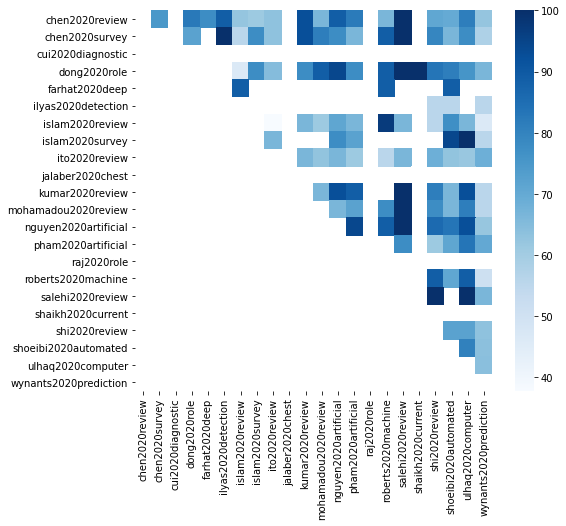

In [146]:
plt.figure(figsize=(8,7))
sns.heatmap(df_agreement_percent, cmap='Blues')

In [147]:
df_agreement_percent[df_agreement_percent >= 90].count()

chen2020review           0
chen2020survey           0
cui2020diagnostic        0
dong2020role             0
farhat2020deep           0
ilyas2020detection       1
islam2020review          0
islam2020survey          0
ito2020review            0
jalaber2020chest         0
kumar2020review          2
mohamadou2020review      0
nguyen2020artificial     2
pham2020artificial       1
raj2020role              0
roberts2020machine       1
salehi2020review         6
shaikh2020current        1
shi2020review            1
shoeibi2020automated     1
ulhaq2020computer        4
wynants2020prediction    0
dtype: int64

In [148]:
df_agreement_percent.mean()

chen2020review                  NaN
chen2020survey            75.000000
cui2020diagnostic               NaN
dong2020role              77.380952
farhat2020deep            77.777778
ilyas2020detection        94.444444
islam2020review           63.376068
islam2020survey           72.222222
ito2020review             59.248677
jalaber2020chest                NaN
kumar2020review           79.259259
mohamadou2020review       71.296296
nguyen2020artificial      79.490741
pham2020artificial        75.802469
raj2020role                     NaN
roberts2020machine        81.597222
salehi2020review          90.123457
shaikh2020current        100.000000
shi2020review             75.710979
shoeibi2020automated      73.422771
ulhaq2020computer         82.530234
wynants2020prediction     60.402549
dtype: float64

In [149]:
df_agreement_percent.describe()

,chen2020review,chen2020survey,cui2020diagnostic,dong2020role,farhat2020deep,ilyas2020detection,islam2020review,islam2020survey,ito2020review,jalaber2020chest,kumar2020review,mohamadou2020review,nguyen2020artificial,pham2020artificial,raj2020role,roberts2020machine,salehi2020review,shaikh2020current,shi2020review,shoeibi2020automated,ulhaq2020computer,wynants2020prediction
count,0.0,1.0,0.0,2.000000,1.000000,2.000000,4.000000,3.000000,5.000000,0.0,5.000000,6.000000,8.000000,9.000000,0.0,8.000000,9.000000,1.0,12.000000,14.000000,14.000000,16.000000
mean,NaN,75.0,NaN,77.380952,77.777778,94.444444,63.376068,72.222222,59.248677,NaN,79.259259,71.296296,79.490741,75.802469,NaN,81.597222,90.123457,100.0,75.710979,73.422771,82.530234,60.402549
std,NaN,NaN,NaN,7.295546,NaN,7.856742,18.186393,9.622504,12.072910,NaN,12.989391,11.218616,11.266876,11.024353,NaN,14.002511,15.158061,NaN,13.757513,10.561254,11.467630,6.641852
min,NaN,75.0,NaN,72.222222,77.777778,88.888889,46.666667,61.111111,37.777778,NaN,66.666667,61.111111,66.666667,61.111111,NaN,55.555556,66.666667,100.0,55.555556,55.555556,61.904762,46.666667
25%,NaN,75.0,NaN,74.801587,77.777778,91.666667,53.333333,69.444444,63.492063,NaN,66.666667,63.888889,70.000000,66.666667,NaN,75.000000,77.777778,100.0,66.666667,66.666667,76.388889,55.555556
50%,NaN,75.0,NaN,77.380952,77.777778,94.444444,58.974359,77.777778,63.492063,NaN,77.777778,66.666667,77.777778,72.222222,NaN,88.888889,100.000000,100.0,78.571429,70.972222,81.481481,62.307692
75%,NaN,75.0,NaN,79.960317,77.777778,97.222222,69.017094,77.777778,64.814815,NaN,92.592593,77.777778,89.814815,82.222222,NaN,88.888889,100.000000,100.0,84.027778,80.409357,91.666667,64.814815
max,NaN,75.0,NaN,82.539683,77.777778,100.000000,88.888889,77.777778,66.666667,NaN,92.592593,88.888889,94.444444,94.444444,NaN,97.222222,100.000000,100.0,100.000000,94.444444,100.000000,70.370370


In [150]:
df_agreement_percent_full = (df_agreement_percent.transpose().fillna(0) + df_agreement_percent.fillna(0)).replace(0, np.nan)

In [151]:
df_agreement_percent_full.describe()

,chen2020review,chen2020survey,cui2020diagnostic,dong2020role,farhat2020deep,ilyas2020detection,islam2020review,islam2020survey,ito2020review,jalaber2020chest,kumar2020review,mohamadou2020review,nguyen2020artificial,pham2020artificial,raj2020role,roberts2020machine,salehi2020review,shaikh2020current,shi2020review,shoeibi2020automated,ulhaq2020computer,wynants2020prediction
count,17.000000,16.000000,0.0,16.000000,4.000000,5.000000,15.000000,9.000000,15.000000,0.0,13.000000,14.000000,15.000000,14.000000,0.0,12.000000,12.000000,1.0,15.000000,16.000000,15.000000,16.000000
mean,76.049422,77.080578,NaN,79.950397,86.111111,71.111111,64.453891,75.925926,62.518519,NaN,80.056980,73.280423,82.901235,74.708995,NaN,79.375000,89.814815,100.0,74.431217,73.272702,81.308054,60.402549
std,11.952636,13.447767,NaN,13.657156,5.555556,21.659543,15.618644,14.433757,7.612662,NaN,14.227435,12.017062,11.877796,9.936411,NaN,14.969163,15.321715,NaN,12.623784,10.300267,12.021609,6.641852
min,61.111111,55.555556,NaN,46.666667,77.777778,55.555556,37.777778,55.555556,37.777778,NaN,55.555556,55.555556,62.222222,61.111111,NaN,51.111111,66.666667,100.0,55.555556,55.555556,61.904762,46.666667
25%,66.666667,66.666667,NaN,75.000000,86.111111,55.555556,55.555556,66.666667,62.433862,NaN,66.666667,66.666667,74.444444,67.592593,NaN,69.791667,75.000000,100.0,66.005291,66.666667,74.074074,55.555556
50%,75.000000,77.777778,NaN,79.629630,88.888889,55.555556,66.666667,77.777778,63.492063,NaN,81.481481,69.444444,86.111111,72.222222,NaN,88.888889,100.000000,100.0,72.222222,70.972222,81.481481,62.307692
75%,82.539683,83.333333,NaN,88.888889,88.888889,88.888889,68.888889,77.777778,66.666667,NaN,92.592593,80.555556,92.592593,81.111111,NaN,88.888889,100.000000,100.0,82.407407,80.787037,90.740741,64.814815
max,100.000000,100.000000,NaN,100.000000,88.888889,100.000000,97.222222,100.000000,68.518519,NaN,100.000000,100.000000,100.000000,94.444444,NaN,97.222222,100.000000,100.0,100.000000,94.444444,100.000000,70.370370


In [152]:
df_agreement_percent_full.describe().transpose()['mean'].mean(), df_agreement_percent_full.describe().transpose()['mean'].std()

(76.98699597772472, 9.345868766626051)

In [153]:
df_agreement_percent_full[df_agreement_percent_full >= 90].count()

chen2020review           2
chen2020survey           3
cui2020diagnostic        0
dong2020role             3
farhat2020deep           0
ilyas2020detection       1
islam2020review          1
islam2020survey          2
ito2020review            0
jalaber2020chest         0
kumar2020review          5
mohamadou2020review      1
nguyen2020artificial     5
pham2020artificial       1
raj2020role              0
roberts2020machine       1
salehi2020review         8
shaikh2020current        1
shi2020review            1
shoeibi2020automated     1
ulhaq2020computer        4
wynants2020prediction    0
dtype: int64

In [154]:
# get list
# flatten it

values = [j for sub in df_agreement_percent.values.tolist() for j in sub]

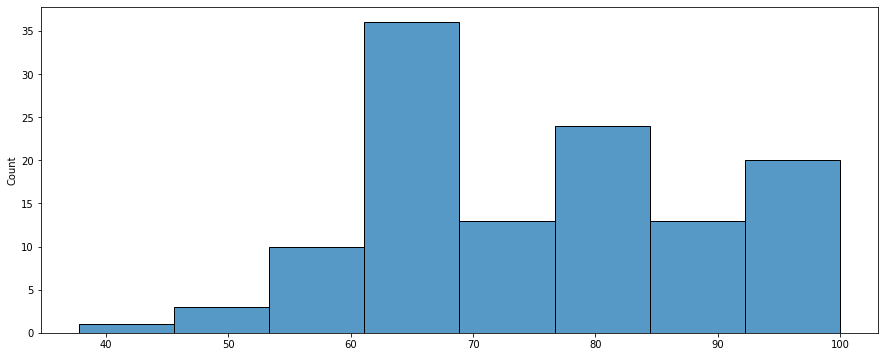

In [155]:
plt.figure(figsize=(15,6))
sns.histplot(values)

In [156]:
std = np.nanstd(values)
std

14.242968170194208